In [1]:
%pip install progressbar2

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Sepehr\Projects\usnet\usnet_venv\Scripts\python.exe -m pip install --upgrade pip' command.


# US-Segmentation with UNet

In [46]:
import tensorflow as tf
print(tf.__version__)

2.4.0


In [3]:
files = tf.keras.utils.get_file('data', origin='https://s5.uupload.ir/files/sepehrglst/usnet_dataset__1.zip', extract=True, cache_dir='.', cache_subdir='data')
print(files)

  5324800/453097340 [..............................] - ETA: 12:27

KeyboardInterrupt: 

In [3]:
import json
from os import path

DATASET_PATH = r'./data/usnet_dataset__1'

with open(path.join(DATASET_PATH, 'info.json')) as metadata_file:
    metadata = json.load(metadata_file)


print(f"Dataset: {metadata['name']}")
print(f"{metadata['discription']}")
print(f"Data Dource(s): {metadata['data_source']}")
print(f"Version: {metadata['version']}")
print(f"Number of training data: {metadata['train_data_count']}")
print(f"Number of validation data: {metadata['validation_data_count']}")



Dataset: usnet_dataset
2D Ultrasound data with segmentation masks
Data Dource(s): CAMUS
Version: 1
Number of training data: 1600
Number of validation data: 200


In [41]:
import numpy as np
from PIL import Image
import progressbar


INPUT_IMAGE_SIZE = (128, 128, 3)
TARGET_IMAGE_SIZE = (128, 128, 4)


def import_image(path, resize_to=None):
  img_obj = Image.open(path)
  if resize_to!=None:
    img_obj = img_obj.resize(resize_to)

  img_data = np.array(img_obj)
  return np.expand_dims(img_data, axis=-1)


def onehot_encode(mask, num_classes=4):
  raw_mask = np.squeeze(mask)
  onehot_mask = np.zeros((raw_mask.shape[0], raw_mask.shape[1], num_classes))
  for int_label in np.unique(raw_mask):
    onehot_mask[:, :, int_label][raw_mask == int_label] = 1
  return onehot_mask

list_data_json = metadata['list_files']


train_images_array = np.zeros((metadata['train_data_count'], *INPUT_IMAGE_SIZE))
train_masks_array = np.zeros((metadata['train_data_count'], *TARGET_IMAGE_SIZE))

validation_images_array = np.zeros((metadata['validation_data_count'], *INPUT_IMAGE_SIZE))
validation_masks_array = np.zeros((metadata['validation_data_count'], *TARGET_IMAGE_SIZE))

train_counter = 0
validation_counter = 0
with progressbar.ProgressBar(max_value = metadata['train_data_count']+metadata['validation_data_count']) as bar:
  for i, json_data_file in enumerate(list_data_json):
    with open(path.join(DATASET_PATH, json_data_file)) as json_data:
      image_metadata = json.load(json_data)
    
    img_file = image_metadata['IMG_FILE']
    mask_file = image_metadata['MASK_FILE']

    img = import_image(path.join(DATASET_PATH, img_file), resize_to=(INPUT_IMAGE_SIZE[0], INPUT_IMAGE_SIZE[1]))
    img = (img - np.min(img))/np.ptp(img)
    mask = import_image(path.join(DATASET_PATH, mask_file), resize_to=(TARGET_IMAGE_SIZE[0], TARGET_IMAGE_SIZE[1])).astype(np.int8)
    mask = onehot_encode(mask)

    if image_metadata['subset'] == 'train':
      train_images_array[train_counter, :, :, :] = np.repeat(img, 3, axis=-1)
      train_masks_array[train_counter, :, :, :] = mask
      train_counter += 1
    else:
      validation_images_array[validation_counter, :, :, :] = np.repeat(img, 3, axis=-1)
      validation_masks_array[validation_counter, :, :, :] = mask
      validation_counter += 1
    bar.update(i)

  0% (0 of 1800) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--
  0% (5 of 1800) |                       | Elapsed Time: 0:00:00 ETA:   0:00:39
  0% (9 of 1800) |                       | Elapsed Time: 0:00:00 ETA:   0:00:41
  0% (14 of 1800) |                      | Elapsed Time: 0:00:00 ETA:   0:00:41
  1% (19 of 1800) |                      | Elapsed Time: 0:00:00 ETA:   0:00:40
  1% (23 of 1800) |                      | Elapsed Time: 0:00:00 ETA:   0:00:39
  1% (28 of 1800) |                      | Elapsed Time: 0:00:00 ETA:   0:00:40
  1% (33 of 1800) |                      | Elapsed Time: 0:00:00 ETA:   0:00:39
  2% (37 of 1800) |                      | Elapsed Time: 0:00:00 ETA:   0:00:40
  2% (44 of 1800) |                      | Elapsed Time: 0:00:00 ETA:   0:00:37
  2% (50 of 1800) |                      | Elapsed Time: 0:00:01 ETA:   0:00:37
  3% (55 of 1800) |                      | Elapsed Time: 0:00:01 ETA:   0:00:36
  3% (61 of 1800) |                     

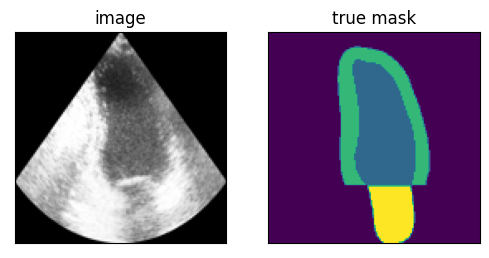

In [44]:
import matplotlib.pyplot as plt


def create_maskimage(mask):
    return np.argmax(mask, axis=-1)

def plot_data(image, mask=None, classified=None, suptitle=''):
    image_labels = ['image']
    data = [image]
    if not isinstance(mask, type(None)):
        image_labels.append('true mask')
        data.append(mask)
    if not isinstance(classified, type(None)):
        image_labels.append('classified mask')
        data.append(classified)

    fig, axes = plt.subplots(1, len(image_labels), dpi=100)

    for title, image, ax in zip(image_labels, data, axes):
        if title=='image':
            ax.imshow(image)
        else:
            ax.imshow(image)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(title)

    fig.suptitle(suptitle)
    return fig

f = plot_data(image = train_images_array[0], mask=create_maskimage(train_masks_array[0]))
    

## Prepare the data

### Load data

In [ ]:
%pip install tensorflow-io

In [49]:
train_ds_unet = tf.data.Dataset.from_tensor_slices((train_images_array, train_masks_array))
validation_ds_unet = tf.data.Dataset.from_tensor_slices((validation_images_array, validation_masks_array))
train_ds_autoencoder = tf.data.Dataset.from_tensor_slices((train_masks_array, train_masks_array))
validation_ds_autoencoder = tf.data.Dataset.from_tensor_slices((validation_masks_array, validation_masks_array))

train_ds_unet.element_spec

(TensorSpec(shape=(128, 128, 3), dtype=tf.float64, name=None),
 TensorSpec(shape=(128, 128, 4), dtype=tf.float64, name=None))

In [22]:
train_ds.element_spec

(TensorSpec(shape=(128, 128, None), dtype=tf.float32, name=None),
 TensorSpec(shape=<unknown>, dtype=tf.float32, name=None))

In [24]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000


train_ds = (
    train_ds
      .cache()
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .prefetch(buffer_size=tf.data.AUTOTUNE)
    )


train_autoencoder_ds = (
    train_autoencoder_ds
      .cache()
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .prefetch(buffer_size=tf.data.AUTOTUNE)
    )


validation_ds = validation_ds.batch(BATCH_SIZE)
validation_autoencoder_ds = validation_autoencoder_ds.batch(BATCH_SIZE)

In [11]:
train_ds.element_spec

(TensorSpec(shape=(None, 128, 128, None), dtype=tf.float32, name=None),
 TensorSpec(shape=<unknown>, dtype=tf.float32, name=None))

In [17]:
train_ds

<PrefetchDataset shapes: ((None, 128, 128, None), (None, 128, 128, None)), types: (tf.float32, tf.float32)>

In [18]:
%pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-ez5r64yl
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-ez5r64yl
  Resolved https://github.com/tensorflow/examples.git to commit a9265a997d0410c431a292e3553646b3b655ea1f


In [93]:
from tensorflow_examples.models.pix2pix import pix2pix


import matplotlib.pyplot as plt

## Segmentation Model

In this part we will try to exaclty define the U-Net model according to the article. As described in the article, the first part of our model is VGG-Net and the synthesizer part is 3D U-Net.


VGG-Net Article:
>K. Simonyan and A. Zisserman. (Sep. 2014). “Very deep convolutional networks for large-scale image recognition.” [Online]. Available: https://arxiv.org/abs/1409.1556

3D U-Net:
>O. Ronneberger, P. Fischer, and T. Brox, “U-net: Convolutional networks for biomedical image segmentation,” in Proc. Int. Conf. MICCAI, 2015, pp. 234–241.

In [23]:
base_model = tf.keras.applications.vgg16.VGG16(input_shape=[128, 128, 3], include_top=False, weights='data/datasets/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')


layer_names = [
    'block1_conv2',
    'block2_conv2',
    'block3_conv3',
    'block4_conv3'
]

base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [24]:
down_stack.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [25]:
from tensorflow_examples.models.pix2pix import pix2pix

with tf.device('/GPU:0'):
    up_stack = [
        pix2pix.upsample(128, 3),  # 16x16 -> 32x32
        pix2pix.upsample(64, 3),   # 32x32 -> 64x64
    ]

In [26]:
def unet_model(output_channels:int):
    
    with tf.device('/GPU:0'):
        inputs = tf.keras.layers.Input(shape=[128, 128, 3])

        # Downsampling through the model
        skips = down_stack(inputs)
        x = skips[-1]
        skips = reversed(skips[:-1])

        # Upsampling and establishing the skip connections
        for up, skip in zip(up_stack, skips):
            x = up(x)
            concat = tf.keras.layers.Concatenate()
            x = concat([x, skip])

        # This is the last layer of the model
        last = tf.keras.layers.Conv2DTranspose(
            filters=output_channels, kernel_size=3, strides=2,
            padding='same')  #64x64 -> 128x128

        x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [20]:
from argparse import ArgumentError
from email.mime import message
import tensorflow as tf
from metrics import DiceCoefficient

In [32]:
from tensorflow.keras.models import load_model


# OUTPUT_CLASSES = 4

# usnet = unet_model(output_channels=OUTPUT_CLASSES)
usnet = load_model('usnet03', compile=False)
usnet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[
                       DiceCoefficient(class_id=1, name = 'dice_class_1'),
                       DiceCoefficient(class_id=2, name = 'dice_class_2'),
                       DiceCoefficient(class_id=3, name = 'dice_class_3')
                       ])

In [33]:
usnet.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              [(None, 128, 128, 64 7635264     input_2[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 32, 32, 128)  590336      model[0][3]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 32, 32, 384)  0           sequential[0][0]                 
                                                                 model[0][2]                

In [31]:
tf.keras.utils.plot_model(usnet)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


(128, 128, 1)


2022-03-04 15:00:24.738363: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101
2022-03-04 15:00:26.730828: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-04 15:00:26.732268: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-04 15:00:26.732324: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2022-03-04 15:00:26.734069: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-04 15:00:26.734315: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


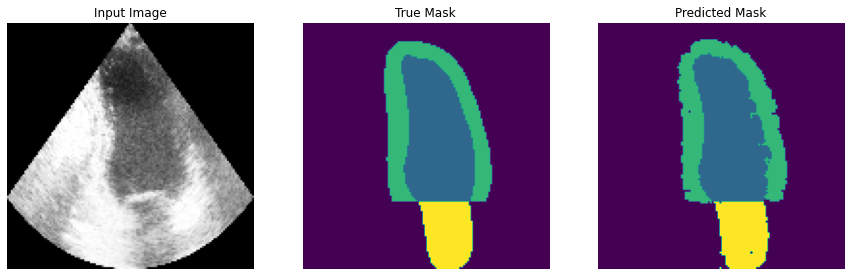

In [23]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = usnet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        print(masks.shape)
        display([images, masks,
                 create_mask(usnet.predict(images[tf.newaxis, ...]))])
    
show_predictions()

In [36]:
from IPython.display import clear_output

class DisplayCallback(tf.keras.callbacks.Callback):
    def __init__(self, dataset, model, ndisp=2,*args, **kwargs):
        super(DisplayCallback).__init__(*args, **kwargs)
        self.ndisp = ndisp
        self.ds = dataset
        self.model = model
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        fig, axes = plt.subplots(self.ndisp, 3)
        counter = 0
        for image_batch, mask_batch in self.ds.take(self.ndisp):
            predict_mask_batch = self.model.predict(image_batch)

            axes[counter][0].imshow(image_batch[0])
            axes[counter][1].imshow(tf.argmax(mask_batch[0], axis=-1))
            axes[counter][2].imshow(tf.argmax(predict_mask_batch[0], axis=-1))
            counter += 1

        fig.suptitle(f'Epoch: {epoch}')
        plt.show()
            

In [ ]:
from tensorflow.keras.callbacks import TensorBoard


tb = TensorBoard('logs/exp03')
callbacks = [tb, DisplayCallback()]

(128, 128, 1)


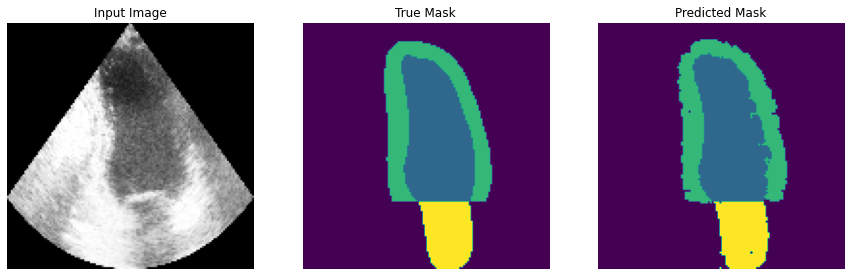


Sample Prediction after epoch 100



In [34]:
EPOCHS = 100

model_history = usnet.fit(train_ds, epochs=EPOCHS,
                          callbacks=callbacks, validation_data = validation_ds)

In [35]:
usnet.save('usnet03')

2022-03-03 19:01:09.244286: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: usnet03/assets


In [30]:

def read_raw_image(image_path, target_size=(128, 128)):
    imgfile = tf.io.read_file(image_path)
    img_fileadd = tf.strings.split(image_path, '.')[0]
    mhd_fileadd = tf.strings.join([img_fileadd, '.mhd'])
    img_dims = read_mhd_data(mhd_fileadd)
    def correct_dims(dims):
        dims_correct = [dims[1], dims[0], dims[2]]
        dims_correct = tf.stack(dims_correct, axis=0)
        return dims_correct
    imgbytes = tf.io.decode_raw(imgfile, out_type=tf.uint8)
    img = tf.reshape(imgbytes, correct_dims(img_dims))
    img = tf.cast(img, tf.float32)
    img = (img - tf.math.reduce_min(img))/(tf.math.reduce_max(img) - tf.math.reduce_min(img))
    if target_size:
        img = tf.image.resize(img, target_size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    img = tf.repeat(img, 3, axis=2)
    return img



def read_mask_image(image_path, target_size=(128, 128)):
    imgfile = tf.io.read_file(image_path)
    img_fileadd = tf.strings.split(image_path, '.')[0]
    mhd_fileadd = tf.strings.join([img_fileadd, '.mhd'])
    img_dims = read_mhd_data(mhd_fileadd)
    def correct_dims(dims):
        dims_correct = [dims[1], dims[0], dims[2]]
        dims_correct = tf.stack(dims_correct, axis=0)
        return dims_correct
    imgbytes = tf.io.decode_raw(imgfile, out_type=tf.uint8)
    img = tf.reshape(imgbytes, correct_dims(img_dims))
    img = tf.cast(img, tf.float32)
    if target_size:
        img = tf.image.resize(img, target_size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return img



def read_mhd_data(mhd_address):
    file_metadata_string = tf.io.read_file(mhd_address)
    print(file_metadata_string)
    # Complete this function later
    

def read_image_and_mask(input_address, target_size=None):
    image = read_raw_image(input_address, target_size=target_size)
    mask_fileadd = tf.strings.split(input_address, '.')[0]
    mask_fileadd = tf.strings.join([mask_fileadd, '_gt.raw'])
    mask_fileadd = tf.squeeze(mask_fileadd)
    mask = read_mask_image(mask_fileadd, target_size=target_size)
    return (image, mask)


def read_mhd_data(mhd_address):
    mhd_data_file = tf.io.read_file(mhd_address)
    mhd_lines = tf.strings.split(mhd_data_file, '\n')
    mhd_lines = tf.strings.split(mhd_lines, ' = ')
    dimsize = mhd_lines[10][1]
    dimsize = tf.strings.split(dimsize, ' ')
    dimsize = tf.boolean_mask(dimsize, mask=tf.math.logical_not(tf.math.equal(dimsize, b'')))
    #dimsize_new = tf.map_fn(tf.strings.to_number, dimsize)
    dimsize = tf.strings.to_number(dimsize)
    dimsize = tf.cast(dimsize, tf.int32)
    #element_number_of_channels = tf.strings.to_number(mhd_lines[11][1])
    return dimsize

### Analyze model

Now let's analyze our model. In order to do so, we will plot and see model performance, data by data and save them.

In [25]:
path_structure = path.join(TRAIN_DATASET_PATH, r'*/*.raw')
file_paths = glob(path_structure)
train_images = list(filter(isimage, file_paths))
train_images


test_dice = DiceCoefficient(class_id=1, name = 'dice_class_1')


with progressbar.ProgressBar(max_value=len(train_images)) as bar:
    for step, image_file in enumerate(train_images):
        test_dice.reset_state()
        image, mask = read_image_and_mask(image_file)
        name = path.basename(image_file).split('.')[0]
        model_output = usnet.predict(image[tf.newaxis, ...])
        test_dice.update_state(mask, model_output)
        pred_mask = create_mask(model_output)
        plt.figure(figsize=(9, 6), dpi=300)
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
        plt.subplot(1, 3, 2)
        plt.xticks([])
        plt.yticks([]) 
        plt.imshow(image)
        plt.imshow(mask, alpha=0.3)
        plt.subplot(1, 3, 3)
        plt.imshow(image)
        plt.imshow(pred_mask, alpha=0.3)
        plt.xticks([])
        plt.yticks([])
        plt.title(f'dice lv = {test_dice.result().numpy()}')
        plt.savefig(path.join('train_images', name+'.jpg'))
        plt.close()
        bar.update(step)

100% (1600 of 1600) |####################| Elapsed Time: 0:16:52 Time:  0:16:52


In [ ]:
!tar -cvf train_images.tar train_images/

In [28]:
path_structure = path.join(VALIDATION_DATASET_PATH, r'*/*.raw')
file_paths = glob(path_structure)
valid_images = list(filter(isimage, file_paths))
valid_images


test_dice = DiceCoefficient(class_id=1, name = 'dice_class_1')


with progressbar.ProgressBar(max_value=len(valid_images)) as bar:
    for step, image_file in enumerate(valid_images):
        test_dice.reset_state()
        image, mask = read_image_and_mask(image_file)
        name = path.basename(image_file).split('.')[0]
        model_output = model.predict(image[tf.newaxis, ...])
        test_dice.update_state(mask, model_output)
        pred_mask = create_mask(model_output)
        plt.figure(figsize=(9, 6), dpi=300)
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
        plt.subplot(1, 3, 2)
        plt.xticks([])
        plt.yticks([]) 
        plt.imshow(image)
        plt.imshow(mask, alpha=0.3)
        plt.subplot(1, 3, 3)
        plt.imshow(image)
        plt.imshow(pred_mask, alpha=0.3)
        plt.xticks([])
        plt.yticks([])
        plt.title(f'dice lv = {test_dice.result().numpy()}')
        plt.savefig(path.join('valid_images', name+'.jpg'))
        plt.close()
        bar.update(step)

100% (200 of 200) |######################| Elapsed Time: 0:02:38 Time:  0:02:38


In [ ]:
!tar -cvf valid_images.tar valid_images/

In [ ]:
with progressbar.ProgressBar(max_value=len(valid_images)) as bar:
    for step, image_file in enumerate(valid_images):
        test_dice.reset_state()
        image, mask = read_image_and_mask(image_file, target_size=(128, 128))
        name = path.basename(image_file).split('.')[0]
        model_output = model.predict(image[tf.newaxis, ...])
        test_dice.update_state(mask, model_output)
        if test_dice.result().numpy()<0.7:
            image, mask = read_image_and_mask(image_file)
            plt.figure(dpi=300)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
            plt.savefig(path.join('low_dice_images', name+'.png'))
        bar.update(step)

In [ ]:
!tar -cvf low_dice_images.tar low_dice_images/

In [ ]:
!tar -cvf logs.tar logs/

In [ ]:
!tar -cvf usnet03.tar usnet03/

## Add Auto-Encoder


In this part we will create an auto-encoder and add it's loss as a regularization term to our network

In [26]:
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.models import Model

def build_encoder(output_dim=64, input_dim=(128, 128, 4)):
    label_map = Input(input_dim, name='label_map_in')
    e = Conv2D(4, 3, activation='relu', padding='same')(label_map)
    e = MaxPool2D(2)(e)
    e = Conv2D(8, 3, activation='relu', padding='same')(e)
    e = MaxPool2D(2)(e)
    e = Conv2D(16, 3, activation='relu', padding='same')(e)
    e = MaxPool2D(2)(e)
    e = Flatten()(e)
    codes = Dense(64, activation='sigmoid')(e)
    return Model(inputs=label_map, outputs=codes)

encoder = build_encoder()
encoder.summary()
    

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
label_map_in (InputLayer)    [(None, 128, 128, 4)]     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 128, 128, 4)       148       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 4)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 8)         296       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 16)        1168      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 16)        0   

In [27]:
from tensorflow.keras.layers import Conv2DTranspose, Reshape, UpSampling2D

def build_decoder(input_dims=64):
    codes = Input(input_dims)
    d = Dense(16*16*16, activation='relu')(codes)
    d = Reshape((16, 16, 16))(d)
    d = UpSampling2D((2, 2))(d)
    d = Conv2D(16, 2, padding='same')(d)
    d = UpSampling2D((2, 2))(d)
    d = Conv2D(8, 2, padding='same')(d)
    d = UpSampling2D((2, 2))(d)
    d = Conv2D(4, 2, padding='same')(d)
    return Model(inputs=codes, outputs=d)

decoder = build_decoder()
decoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense_3 (Dense)              (None, 4096)              266240    
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 16)        0         
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 16)        1040      
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 64, 8)         520 

In [28]:
ae_input = Input((128, 128, 4))
codes = encoder(ae_input)
rconst = decoder(codes)
ae_model = Model(inputs = ae_input, outputs=rconst)
ae_model.summary()


Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 4)]     0         
_________________________________________________________________
model_3 (Functional)         (None, 64)                263820    
_________________________________________________________________
model_4 (Functional)         (None, 128, 128, 4)       267932    
Total params: 531,752
Trainable params: 531,752
Non-trainable params: 0
_________________________________________________________________


In [39]:
from IPython.display import clear_output

class DisplayCallback2(tf.keras.callbacks.Callback):
    def __init__(self, dataset, model, ndisp=2,*args, **kwargs):
        super(DisplayCallback).__init__(*args, **kwargs)
        self.ndisp = ndisp
        self.ds = dataset
        self.model = model
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        fig, axes = plt.subplots(self.ndisp, 3)
        counter = 0
        for image_batch, mask_batch in self.ds.take(self.ndisp):
            predict_mask_batch = self.model.predict(image_batch)

            axes[counter][0].imshow(tf.argmax(image_batch[0], axis=-1))
            axes[counter][1].imshow(tf.argmax(mask_batch[0], axis=-1))
            axes[counter][2].imshow(tf.argmax(predict_mask_batch[0], axis=-1))
            counter += 1

        fig.suptitle(f'Epoch: {epoch}')
        plt.show()

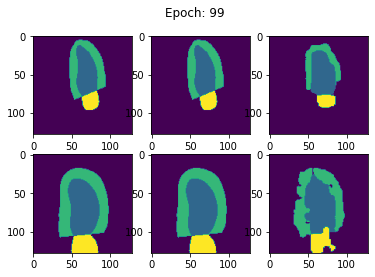

In [40]:
callbacks = [DisplayCallback2(model=ae_model, dataset=validation_autoencoder_ds)]

ae_model.compile(loss = tf.keras.losses.MeanAbsoluteError(), optimizer='adam')
ae_model.fit(train_autoencoder_ds, epochs=100, validation_data=validation_autoencoder_ds, callbacks=callbacks)

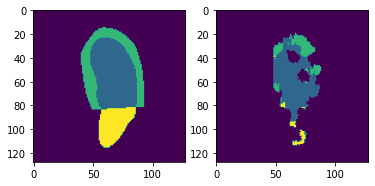

In [30]:
for image_in, image_tar in train_autoencoder_ds.take(1):
    preds = ae_model.predict(image_in)
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(tf.argmax(image_tar[2], axis=-1))
    plt.subplot(1, 2, 2)
    plt.imshow(tf.argmax(preds[2], axis=-1))
    plt.show()